In [ ]:
from google.colab import drive



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

An error occurred while trying to fetch google/ddpm-celebahq-256: google/ddpm-celebahq-256 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


diffusion_pytorch_model.bin:   0%|          | 0.00/455M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
RePaint:  10%|█         | 100/1000 [01:11<29:13,  1.95s/it]

saving intermediate result


RePaint:  20%|██        | 200/1000 [02:21<26:02,  1.95s/it]

saving intermediate result


RePaint:  30%|███       | 300/1000 [03:32<22:39,  1.94s/it]

saving intermediate result


RePaint:  40%|████      | 400/1000 [04:42<19:22,  1.94s/it]

saving intermediate result


RePaint:  50%|█████     | 500/1000 [05:52<16:12,  1.94s/it]

saving intermediate result


RePaint:  60%|██████    | 600/1000 [07:03<12:55,  1.94s/it]

saving intermediate result


RePaint:  70%|███████   | 700/1000 [08:13<09:41,  1.94s/it]

saving intermediate result


RePaint:  80%|████████  | 800/1000 [09:24<06:29,  1.95s/it]

saving intermediate result


RePaint:  90%|█████████ | 900/1000 [10:34<03:14,  1.94s/it]

saving intermediate result


RePaint: 100%|██████████| 1000/1000 [11:45<00:00,  1.42it/s]

saving intermediate result


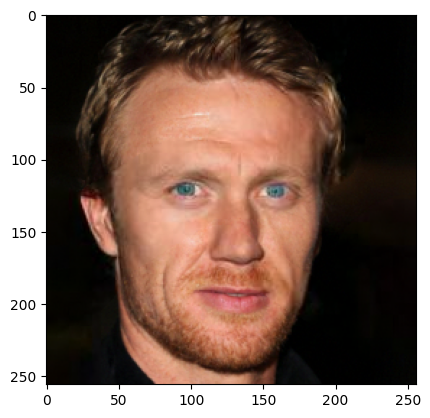

In [1]:
import torch
from diffusers import UNet2DModel, DDPMScheduler
from torchvision import transforms
import PIL.Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from typing import List


sample_to_pil = transforms.Compose([
        transforms.Lambda(lambda t: t.squeeze(0)), # CHW to HWC
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: (t + 1) * 127.5), # [-1, 1] to [0, 255]
        transforms.Lambda(lambda t: torch.clamp(t, 0, 255)),
        transforms.Lambda(lambda t: t.cpu().detach().numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])


class RePaintScheduler:
    def __init__(self, ddpm_scheduler: DDPMScheduler, resample_steps: int = 10, jump_length: int = 10):
        self.ddpm = ddpm_scheduler
        self.resample_steps = resample_steps
        self.jump_length = jump_length
        self.timesteps = list(range(ddpm_scheduler.num_train_timesteps - 1, -1, -1))

    def q_sample_known(self, x0: torch.Tensor, t: int) -> torch.Tensor:
        alpha_bar = self.ddpm.alphas_cumprod[t].clamp(min=1e-5)
        noise = torch.randn_like(x0)
        return (alpha_bar.sqrt() * x0) + ((1 - alpha_bar).sqrt() * noise)

    def reverse_denoise(self, x_t: torch.Tensor, t: int, unet: UNet2DModel) -> torch.Tensor:
        beta_t = self.ddpm.betas[t]
        alpha_t = self.ddpm.alphas[t]
        alpha_bar = self.ddpm.alphas_cumprod[t].clamp(min=1e-5)

        eps_pred = unet(x_t, t).sample
        mu = (1.0 / alpha_t.sqrt()) * (x_t - ((beta_t / (1 - alpha_bar).sqrt()) * eps_pred))

        if t > 0:
            return mu + beta_t.sqrt() * torch.randn_like(x_t)
        return mu

    def forward_jump(self, x_prev: torch.Tensor, t: int) -> torch.Tensor:
        t_next = min(t + self.jump_length, 999)
        alpha_bar = self.ddpm.alphas_cumprod[t].clamp(min=1e-5)
        # print(f"\n t_next: {t_next}")
        alpha_bar_next = self.ddpm.alphas_cumprod[t_next].clamp(min=1e-5)
        ratio = (alpha_bar_next / alpha_bar).clamp(min=1e-5, max=1.0)
        noise = torch.randn_like(x_prev)
        return ratio.sqrt() * x_prev + (1 - ratio).sqrt() * noise


@torch.no_grad()
def repaint(
    unet: UNet2DModel,
    scheduler: RePaintScheduler,
    x0: torch.Tensor,
    mask: torch.Tensor
) -> torch.Tensor:
    """
    RePaint inpainting driver.
    Args:
      unet: pretrained UNet2DModel for noise prediction.
      scheduler: configured RePaintScheduler instance.
      x0: original image [-1,1], shape [B,C,H,W].
      mask: binary mask (1=inpaint, 0=keep), same shape.
    Returns:
      Inpainted image tensor.
    """
    device = x0.device
    x = torch.randn_like(x0).to(device)  # start from noise

    for t in tqdm(scheduler.timesteps, desc="RePaint"):
        if t % 10 == 0:
            for u in range(scheduler.resample_steps):
                if u < scheduler.resample_steps - 1:
                    x = scheduler.forward_jump(x, t)
                    for i in range(scheduler.jump_length):
                        x = scheduler.reverse_denoise(x, t + scheduler.jump_length - i, unet)
        x_known = scheduler.q_sample_known(x0, t)
        x_unknown = scheduler.reverse_denoise(x, t, unet)
        x = mask * x_known + (1 - mask) * x_unknown

        if t % 100 == 0:
            print("saving intermediate result")
            result = x
            result = result.squeeze(0).cpu()
            result = (result + 1) / 2
            result = transforms.ToPILImage()(result.clamp(0, 1))
            result.save(f"result_{t}.png")

    return x


if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model_id = "google/ddpm-celebahq-256"

    T = 25
    betas = torch.linspace(1e-4, 0.02, T)
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)

    model = UNet2DModel.from_pretrained("google/ddpm-celebahq-256").to(device).eval()
    ddpm_scheduler = DDPMScheduler.from_pretrained(model_id)
    scheduler = RePaintScheduler(
        ddpm_scheduler=ddpm_scheduler,
        resample_steps=10,
        jump_length=5,
    )


    data_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t * 2) - 1),
        transforms.Lambda(lambda t: t.unsqueeze(0))
    ])

    mask_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Lambda(lambda t: t.unsqueeze(0))
    ])

    image = PIL.Image.open("celeba_00.jpg")
    mask = PIL.Image.open("000013.png")
    image = data_transform(image).to(device)
    mask = mask_transform(mask).to(device)

    with torch.no_grad():
      result = repaint(model, scheduler, image, mask)

    result = result.squeeze(0).cpu()
    result = (result + 1) / 2
    result = transforms.ToPILImage()(result.clamp(0, 1))
    result.save("result.png")

    plt.imshow(result)
    plt.show()




An error occurred while trying to fetch google/ddpm-celebahq-256: google/ddpm-celebahq-256 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


beginning repaint


100%|██████████| 1000/1000 [03:03<00:00,  5.45it/s]


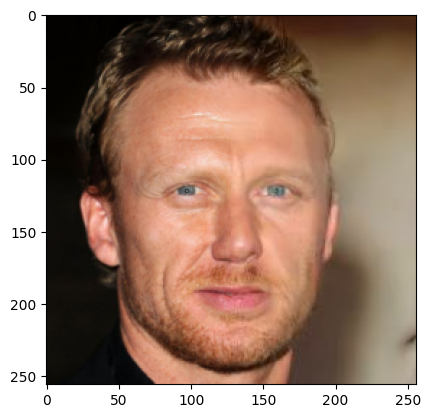